In [1]:
import torch
import random
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Воспроизводимость эксперимента

random seed - номер последовательности случайных чисел, которую выдаст нам случайный генератор

In [2]:
#  зафиксируем все случайные генераторы
#  ноль означает, что мы всегда используем нулевую последовательность при вызове генератора
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Задача классификации

In [3]:
# позырим винишко: 178 вин, 13 параметров у каждой
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], # используем всего 2 колонки
    wine.target, 
    test_size=0.3, 
    shuffle=True)

# оборачиваем в тензоры:
# дробные числа - в float тензор, если числа не дробные - в long тензор. 
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [5]:
class WineNet(torch.nn.Module):    #  отнаследуемся от torch.nn.Module
    def __init__(self, n_hidden_neurons):  #  принимаем на вход количество скрытых нейронов
        
        super(WineNet, self).__init__()
        # попробуем 3 слоя, 2 из которых скрытые
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)  #  fully connected слой - из двух входов (у нас две колонки для каждой бутылки вина)
                                                         #  на выходе N скрытых нейронов
        self.activ1 = torch.nn.Sigmoid()   #  активация: сигмоида
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons) #  скрытый слой, который из N нейронов, 
                                                                       #  превращает их тоже в N нейронов
        self.activ2 = torch.nn.Sigmoid()   #  активация: сигмоида
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)  #   fully connected слой, который выдаёт три нейрона, 
                                                         #   каждый нейрон будет отвечать за свой класс.
        self.sm = torch.nn.Softmax(dim=1)  #  на выходе этих трёх нейронов будут некоторые числа, 
                                           #  которые после этого мы передадим в софтмакс, и получим вероятности классов.
        
    def forward(self, x): #  реализуем граф нашей нейронной сети
        x = self.fc1(x)   #  передаём двухмерный тензор с двумя колоннами в первый fully connected слой
        x = self.activ1(x) #  в первую активацию
        x = self.fc2(x)   #  во второй fully connected слой
        x = self.activ2(x) #  во вторую активацию
        x = self.fc3(x)  #  в третий fully connected слой, у которого три выхода.
        return x

    #  для подсчета вероятностей
    def inference(self, x):
        x = self.forward(x)  #  вызывает forward
        x = self.sm(x)  #  подсчет софтмакс
        return x
    
wine_net = WineNet(5)  # скрытых нейронов 5

In [6]:
#  инициализация функции потерь
loss = torch.nn.CrossEntropyLoss()

#  оптимайзер
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3) # передаём все параметры нейронной сети

Обучение в реальной жизни происходит по частям данных. Они называются батчи (batch). <br>
<li> мы должны отрезать некоторый кусочек наших данных, посчитать по нему loss, посчитать по нему градиентный шаг, сделать градиентный шаг,
<li> затем взять следующий кусочек, и так далее.
    
<br>Одна эпоха, то есть итерация просмотра всего датасета, у нас бьётся на много маленьких частей.

In [8]:
np.random.permutation(5) #  дает numpy.array размером "5", с числами от 0 до 4 включительно, случайно перемешанными
# если мы сюда подставим размер нашего трейнового датасета, 
# то мы получим некоторые индексы, в случайном порядке. 
# получается, что если мы от нашего датасета возьмём эти индексы, то мы получим "пошафленный", перемешанный датасет. 

array([2, 3, 1, 4, 0])

In [9]:
batch_size = 10  #  каждую эпоху мы будем шаффлить датасет, и потом резать его на части. 
                 #  допустим, эти части будут размером десять элементов.

for epoch in range(5000):
    order = np.random.permutation(len(X_train)) # переменная "order" определяется каждую эпоху, 
                                                # которая говорит порядок индексов, который нужно применить к датасету.
    
    
    #  каждую эпоху мы будем делать перемешивание нашего датасета, 
    #  определять переменную order, которая отвечает за порядок элементов.
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]  #  после этого мы из этого порядка будем вычислять некоторое подмножество, 
                                                                   #  начиная со start_index, который будет 0, 10, 20 и так далее, до конца батча. 
        # то есть batch_indexes -- это некоторые индексы, которые соответствуют текущему батчу. 
        
        #  эти batch_indexes, мы их возьмём из X_train и y_train, чтобы получить и данные, и ответы.
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) #  получим некоторые prediction. это выходы на последних трех нейронах.
        
        loss_value = loss(preds, y_batch) #  посчитаем loss на выходах нейронной сети и реальных значениях
        loss_value.backward()  #  посчитаем производную у результата выполнения loss функции
        
        optimizer.step()
        
    if epoch % 100 == 0: #  Каждые 100 эпох будем вычислять метрики на тестовом датасете 
                         #  и смотреть, обучается у нас нейросеть, или нет. 
        
        
        
        test_preds = wine_net.forward(X_test)  # каждые 100 эпох мы делаем forward по тестовым данным, 
                                               # получаем тестовые prediction
        test_preds = test_preds.argmax(dim=1)  # вычисляем, какой выход был максимальный. 
                                  # посчитать argmax у выходов нейронной сети, это будет номер нейрона, 
                                  # и сравнить его с тем номером класса, который находится в Y_test.
        print((test_preds == y_test).float().mean()) #  какая доля вот этого совпадения, 
                                                     #  когда у нас нейрон с максимальным выходом совпал с реально правильным классом. 

tensor(0.4074)
tensor(0.4074)
tensor(0.4630)
tensor(0.5000)
tensor(0.4259)
tensor(0.4074)
tensor(0.5185)
tensor(0.5185)
tensor(0.4444)
tensor(0.4259)
tensor(0.5000)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.7407)
tensor(0.6852)
tensor(0.6481)
tensor(0.6852)
tensor(0.6481)
tensor(0.6852)
tensor(0.6852)
tensor(0.6852)
tensor(0.7222)
tensor(0.7037)
tensor(0.7407)
tensor(0.7593)
tensor(0.7778)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)


(!) необязательно ждать, пока обучение закончится, можно в любой момент его остановить руками, если мы чувствуем, что нейросеть уже сошлась и значения не изменяются. 

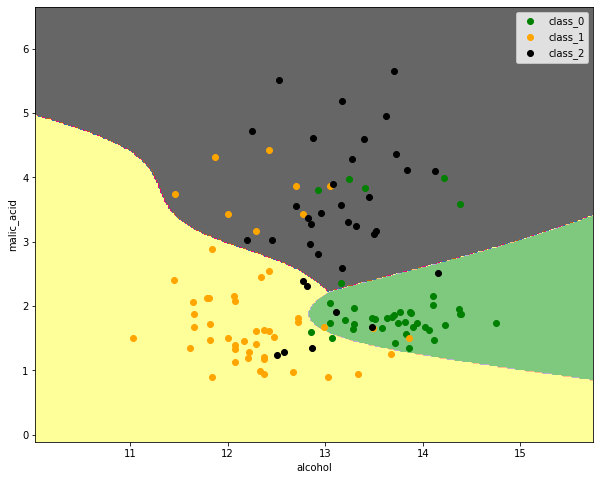

In [10]:
# визуализация
# точками обозначен трейновый датасет, то есть те точки, на которых обучалась наша нейронная сеть, 
#а заполненными областями -- то, как бы нейросеть классифицировала точки в соответствующих значениях.

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()